In [2]:
!pip install spectral
!pip install matlab

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio
import matplotlib.pyplot as plt
import spectral

Load dataset

In [6]:
import scipy.io as sio

# Load Salinas dataset
salinas_data = sio.loadmat('/content/Salinas_corrected.mat', simplify_cells=True)
salinas = salinas_data['salinas_corrected']

# Load Salinas ground truth
salinas_gt_data = sio.loadmat('/content/Salinas_gt.mat', simplify_cells=True)
salinas_gt = salinas_gt_data['salinas_gt']

Show data*set*

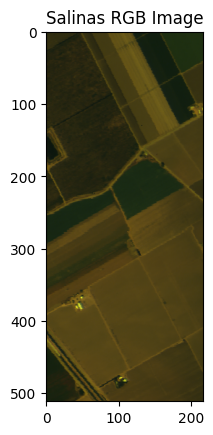

The data shape of the Salinas dataset is . (512, 217, 204)
Salinas ground truth has the data shape . (512, 217)


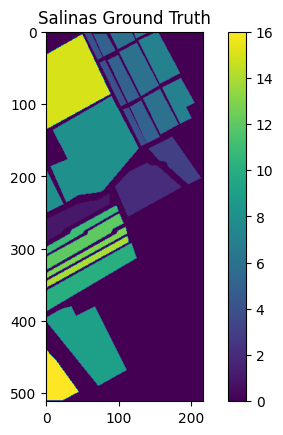

In [12]:
import matplotlib.pyplot as plt
import numpy as np
# Show Salinas
plt.title("Salinas Dataset")
rgb_image = salinas[:, :, [30, 15, 2]]  # Select three channels to merge
scaling_factor = 255.0 / np.max(rgb_image)  # Calculate the scaling factor
rgb_image = (rgb_image * scaling_factor).astype(np.uint8)  # Scaling pixel values and converting to unsigned integer types
plt.imshow(rgb_image)
plt.title("Salinas RGB Image")
plt.show()

salinas_shape = salinas.shape
salinas_gt_shape = salinas_gt.shape

# Print data shapes
print("The data shape of the Salinas dataset is .", salinas_shape)
print("Salinas ground truth has the data shape .", salinas_gt_shape)



# Show Salinas ground truth
plt.imshow(salinas_gt)
plt.title("Salinas Ground Truth")
plt.colorbar()
plt.show()


Data processing

In [8]:
# Reshape the data to a 2D array
salinas_2d = salinas.reshape(-1, salinas.shape[2])

# Apply standardization to the data
salinas_2d = (salinas_2d - np.mean(salinas_2d, axis=0)) / np.std(salinas_2d, axis=0)

Split dataset

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset and labels into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(salinas, salinas_gt, test_size=0.2, random_state=42)

# Print the shape of the split training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (409, 217, 204)
Test set shape: (103, 217, 204)


Choose modle and Training


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Creating DBSCAN objects
dbscan = DBSCAN(eps=0.6, min_samples=9)

# Clustering with DBSCAN
labels = dbscan.fit_predict(salinas_2d)

# Print the category to which each sample belongs
print(labels)

# Obtain core and noise samples for clustering
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
noise_mask = labels == -1

# Print the number of core and noise samples
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(noise_mask).count(True)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


[-1 -1 -1 ... -1 -1 -1]
Estimated number of clusters: 1
Estimated number of noise points: 111072


In [ ]:
# Get the assigned cluster labels
labels = dbscan.labels_

# Analyze the cluster labels
unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - 1  # Subtracting the noise point cluster

print("Cluster labels:", unique_labels)
print("Number of clusters:", n_clusters)


Cluster labels: [-1  0]
Number of clusters: 1


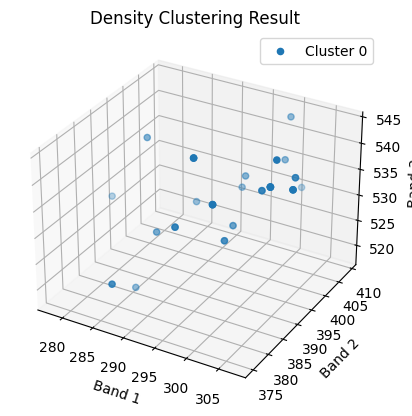

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert the data to 3D for visualization
salinas_3d = salinas.reshape(-1, salinas.shape[2])

# Create a scatter plot of the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label in unique_labels:
    if label == -1:
        continue
    # Get the indices of samples belonging to the current cluster label
    indices = np.where(labels == label)[0]
    # Get the corresponding samples in the 3D dataset
    samples = salinas_3d[indices, :]
    # Scatter plot the samples with the corresponding color
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], label=f'Cluster {label}')

# Set labels and title
ax.set_xlabel('Band 1')
ax.set_ylabel('Band 2')
ax.set_zlabel('Band 3')
ax.set_title('Density Clustering Result')

# Add legend
ax.legend()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/pytho

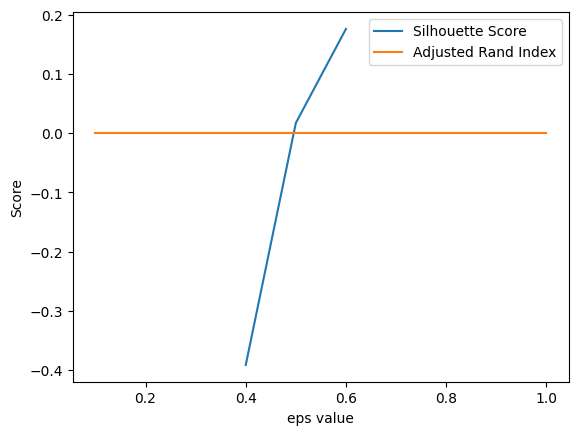

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt

# Define the range of eps values to compare
eps_values = np.linspace(0.1, 1.0, 10)  # Example: from 0.1 to 1.0 with 10 values

# Set other parameters for clustering and evaluation
min_samples = 5  # Minimum number of samples in a neighborhood

# Define a function to perform clustering and evaluation for a given eps value
def perform_clustering(data_block, eps_value):
    # Perform PCA dimensionality reduction
    pca = PCA(n_components=10)
    data_block_reshaped = np.reshape(data_block, (-1, data_block.shape[-1]))
    data_block_pca = pca.fit_transform(data_block_reshaped)

    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps_value, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    labels = clustering.fit_predict(data_block_pca)

    # Compute Silhouette Score (if there are at least 2 clusters)
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(data_block_pca, labels)
    else:
        silhouette = np.nan

    # Compute Adjusted Rand Index
    true_labels = data_block[..., 0]  # Assuming true labels are stored in the first channel
    ari = adjusted_rand_score(true_labels.flatten(), labels)

    # Return clustering result, Silhouette Score, and Adjusted Rand Index
    return labels, silhouette, ari

# Create an empty result array
results = []
silhouette_scores = []
ari_scores = []

# Generate random data block (example)
data_block = np.random.rand(100, 100, 10)

# Process data block for each eps value
for eps_value in eps_values:
    # Perform clustering and evaluation
    processed_block, silhouette, ari = perform_clustering(data_block, eps_value)

    # Store the results
    results.append(processed_block)
    silhouette_scores.append(silhouette)
    ari_scores.append(ari)

# Plotting the results
plt.plot(eps_values, silhouette_scores, label='Silhouette Score')
plt.plot(eps_values, ari_scores, label='Adjusted Rand Index')
plt.xlabel('eps value')
plt.ylabel('Score')
plt.legend()
plt.show()



K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

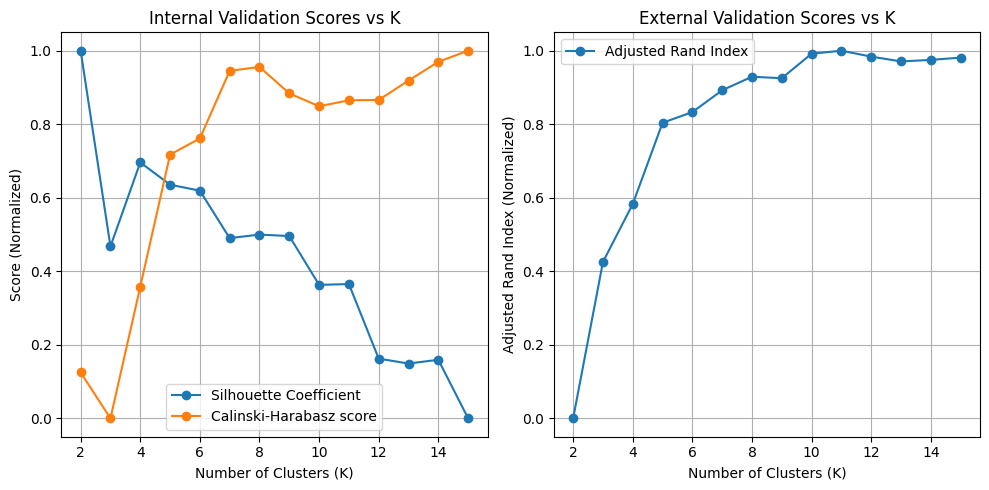

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
import matplotlib.pyplot as plt

# Convert datasets to 2D arrays
salinas_2d = salinas.reshape(-1, salinas.shape[-1])

# Perform PCA dimensionality reduction
pca = PCA(n_components=20)
salinas_pca = pca.fit_transform(salinas_2d)

# Define a range of K values to evaluate
k_range = range(2, 16)

# Initialize empty lists to store scores
silhouette_scores = []
calinski_scores = []
adjusted_rand_scores = []

# Iterate over each K value
for k in k_range:
    # Create KMeans object with the current K value
    kmeans = KMeans(n_clusters=k, init='k-means++')

    # Clustering on the PCA-transformed Salinas dataset
    kmeans.fit(salinas_pca)

    # Get clustering result labels
    labels = kmeans.labels_

    # Calculate Silhouette Coefficient
    silhouette_avg = silhouette_score(salinas_pca, labels)
    silhouette_scores.append(silhouette_avg)

    # Calculate Calinski-Harabasz score
    calinski_score = calinski_harabasz_score(salinas_pca, labels)
    calinski_scores.append(calinski_score)

    # Assuming true labels are stored in the first channel of 'salinas' dataset
    true_labels = salinas[..., 0].flatten()

    # Calculate Adjusted Rand Index
    adjusted_rand_index = adjusted_rand_score(true_labels, labels)
    adjusted_rand_scores.append(adjusted_rand_index)

# Normalize the scores using MinMaxScaler
scaler = MinMaxScaler()
silhouette_scores_normalized = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1))
calinski_scores_normalized = scaler.fit_transform(np.array(calinski_scores).reshape(-1, 1))
adjusted_rand_scores_normalized = scaler.fit_transform(np.array(adjusted_rand_scores).reshape(-1, 1))

# Plot the curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores_normalized, marker='o', label='Silhouette Coefficient')
plt.plot(k_range, calinski_scores_normalized, marker='o', label='Calinski-Harabasz score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score (Normalized)')
plt.title('Internal Validation Scores vs K')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, adjusted_rand_scores_normalized, marker='o', label='Adjusted Rand Index')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Adjusted Rand Index (Normalized)')
plt.title('External Validation Scores vs K')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Hierarchical clustering

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming you have already loaded the Salinas dataset and stored it in the variable 'salinas'

# Flatten the Salinas dataset into a 2D array
salinas_2d = salinas.reshape(-1, salinas.shape[-1])

# Create a PCA object and specify the desired number of dimensions
pca = PCA(n_components=2)

# Perform PCA dimensionality reduction
reduced_data = pca.fit_transform(salinas_2d)

# Print the shape of the reduced data
print("Reduced data shape:", reduced_data.shape)

# Print the explained variance ratio of the principal components
print("Explained variance ratio of the principal components:", pca.explained_variance_ratio_)

# Print the reduced data
print("Reduced data:")
print(reduced_data)


Reduced data shape: (111104, 2)
Explained variance ratio of the principal components: [0.74473713 0.23531325]
Reduced data:
[[-6136.41576976 -4385.65160149]
 [-6196.98671752 -4360.59026602]
 [-6359.53881669 -4693.89281084]
 ...
 [-6740.51771876 -4127.14790636]
 [-6763.54621803 -4135.16792566]
 [-6664.10492775 -4017.88535454]]


Block Index: (0, 0)
Linkage: ward
Silhouette Score: 0.4635172571269197
Adjusted Rand Index: 0.003968567536757788

Block Index: (0, 0)
Linkage: complete
Silhouette Score: 0.509012474733464
Adjusted Rand Index: 0.004390350988366044

Block Index: (0, 0)
Linkage: average
Silhouette Score: 0.6613100690041618
Adjusted Rand Index: 0.00359888630645511

Block Index: (0, 80)
Linkage: ward
Silhouette Score: 0.7409774889615802
Adjusted Rand Index: 0.011773898541241952

Block Index: (0, 80)
Linkage: complete
Silhouette Score: 0.6732153289428637
Adjusted Rand Index: 0.011686356711326167

Block Index: (0, 80)
Linkage: average
Silhouette Score: 0.6969301101065294
Adjusted Rand Index: 0.011776713945672432

Block Index: (0, 160)
Linkage: ward
Silhouette Score: 0.7255583022527347
Adjusted Rand Index: 0.010077266807043826

Block Index: (0, 160)
Linkage: complete
Silhouette Score: 0.7100028945792115
Adjusted Rand Index: 0.009457056065117887

Block Index: (0, 160)
Linkage: average
Silhouette Score: 0.585539

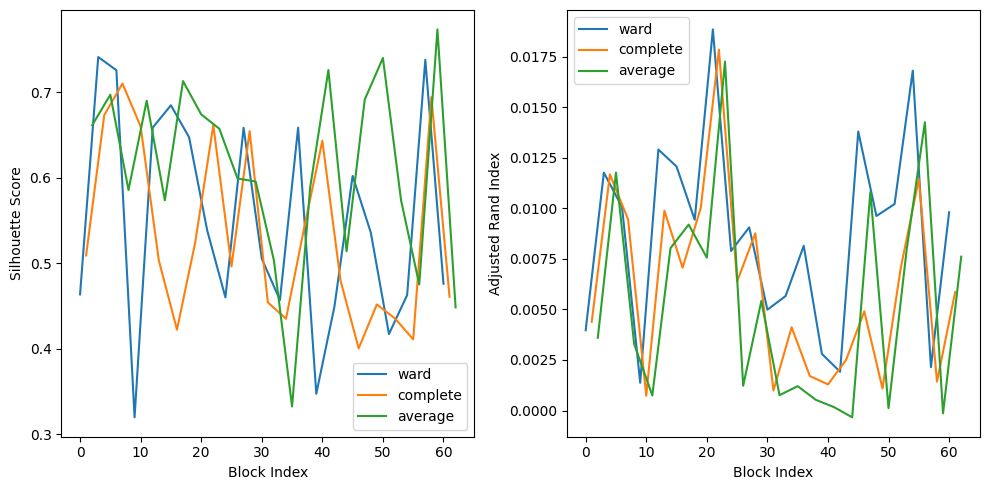

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already loaded the Salinas dataset and stored it in the variable 'salinas'

# Set block size and overlap
block_size = 100  # Size of each block
overlap = 20  # Size of overlap between blocks

# Define a function to perform clustering and evaluation
def perform_clustering(data_block, linkage):
    # Perform PCA dimensionality reduction
    pca = PCA(n_components=20)
    data_block_reshaped = np.reshape(data_block, (-1, data_block.shape[-1]))
    data_block_pca = pca.fit_transform(data_block_reshaped)

    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage)
    labels = clustering.fit_predict(data_block_pca)

    # Compute Silhouette Score
    silhouette = silhouette_score(data_block_pca, labels)

    # Compute Adjusted Rand Index
    true_labels = data_block[..., 0]  # Assuming true labels are stored in the first channel
    ari = adjusted_rand_score(true_labels.flatten(), labels)

    # Return clustering result, Silhouette Score, and Adjusted Rand Index
    return labels, silhouette, ari

# Create an empty result array
result = np.zeros((salinas.shape[0], salinas.shape[1]), dtype=int)
silhouette_scores = []
ari_scores = []

# Process data block by block
for row in range(0, salinas.shape[0], block_size-overlap):
    for col in range(0, salinas.shape[1], block_size-overlap):
        # Compute the boundary indices of the current block
        start_row = row
        end_row = min(row + block_size, salinas.shape[0])
        start_col = col
        end_col = min(col + block_size, salinas.shape[1])

        # Load the current block of data
        data_block = salinas[start_row:end_row, start_col:end_col]

        # Process the current block of data for each linkage method
        for linkage in ['ward', 'complete', 'average']:
            processed_block, silhouette, ari = perform_clustering(data_block, linkage)

            # Fill the processed result into the result array
            result[start_row:end_row, start_col:end_col] = processed_block.reshape(data_block.shape[:2])
            silhouette_scores.append(silhouette)
            ari_scores.append(ari)

            # Output Silhouette Score and Adjusted Rand Index for each data block
            print(f"Block Index: ({start_row}, {start_col})")
            print(f"Linkage: {linkage}")
            print(f"Silhouette Score: {silhouette}")
            print(f"Adjusted Rand Index: {ari}")
            print()

# Plotting the results
linkage_methods = ['ward', 'complete', 'average']
scores = [silhouette_scores, ari_scores]

plt.figure(figsize=(10, 5))

for i, score_type in enumerate(['Silhouette Score', 'Adjusted Rand Index']):
    plt.subplot(1, 2, i+1)
    for j, linkage in enumerate(linkage_methods):
        indices = range(j, len(scores[i]), len(linkage_methods))
        plt.plot(indices, scores[i][j::len(linkage_methods)], label=linkage)
    plt.xlabel('Block Index')
    plt.ylabel(score_type)
    plt.legend()

plt.tight_layout()
plt.show()





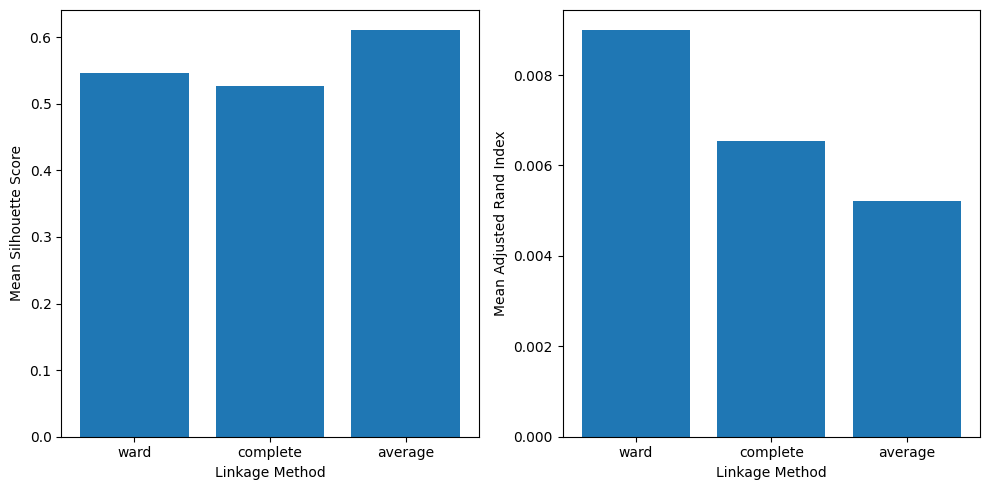

Mean Silhouette Scores:
ward: 0.5465723154213349
complete: 0.5259775747062384
average: 0.6102166535253277

Mean Adjusted Rand Index:
ward: 0.008988539216502887
complete: 0.006533878518619383
average: 0.005224561457801494


In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already loaded the Salinas dataset and stored it in the variable 'salinas'

# Set block size and overlap
block_size = 100  # Size of each block
overlap = 20  # Size of overlap between blocks

# Define a function to perform clustering and evaluation
def perform_clustering(data_block, linkage):
    # Perform PCA dimensionality reduction
    pca = PCA(n_components=20)
    data_block_reshaped = np.reshape(data_block, (-1, data_block.shape[-1]))
    data_block_pca = pca.fit_transform(data_block_reshaped)

    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage)
    labels = clustering.fit_predict(data_block_pca)

    # Compute Silhouette Score
    silhouette = silhouette_score(data_block_pca, labels)

    # Compute Adjusted Rand Index
    true_labels = data_block[..., 0]  # Assuming true labels are stored in the first channel
    ari = adjusted_rand_score(true_labels.flatten(), labels)

    # Return clustering result, Silhouette Score, and Adjusted Rand Index
    return labels, silhouette, ari

# Create an empty result array
result = np.zeros((salinas.shape[0], salinas.shape[1]), dtype=int)
silhouette_scores = []
ari_scores = []

# Process data block by block
for row in range(0, salinas.shape[0], block_size-overlap):
    for col in range(0, salinas.shape[1], block_size-overlap):
        # Compute the boundary indices of the current block
        start_row = row
        end_row = min(row + block_size, salinas.shape[0])
        start_col = col
        end_col = min(col + block_size, salinas.shape[1])

        # Load the current block of data
        data_block = salinas[start_row:end_row, start_col:end_col]

        # Process the current block of data for each linkage method
        for linkage in ['ward', 'complete', 'average']:
            processed_block, silhouette, ari = perform_clustering(data_block, linkage)

            silhouette_scores.append(silhouette)
            ari_scores.append(ari)

# Compute the mean Silhouette Score and Adjusted Rand Index for each linkage method
mean_silhouette_scores = [np.mean(silhouette_scores[i::3]) for i in range(3)]
mean_ari_scores = [np.mean(ari_scores[i::3]) for i in range(3)]

# Plotting the results
linkage_methods = ['ward', 'complete', 'average']
scores = [mean_silhouette_scores, mean_ari_scores]

plt.figure(figsize=(10, 5))

for i, score_type in enumerate(['Mean Silhouette Score', 'Mean Adjusted Rand Index']):
    plt.subplot(1, 2, i+1)
    plt.bar(linkage_methods, scores[i])
    plt.xlabel('Linkage Method')
    plt.ylabel(score_type)

plt.tight_layout()
plt.show()

print("Mean Silhouette Scores:")
for linkage, score in zip(linkage_methods, mean_silhouette_scores):
    print(f"{linkage}: {score}")

print("\nMean Adjusted Rand Index:")
for linkage, score in zip(linkage_methods, mean_ari_scores):
    print(f"{linkage}: {score}")
